# Binary Classification on the Edibility of Mushrooms
Students:
* _Andrea Pepe (matr. 0315903)_
* _Matteo Ciccaglione (matr. 0315944)_ 

In [85]:
import pandas as pd
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.discriminant_analysis
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [107]:
import matplotlib.colors as mcolors
plt.style.use('bmh')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

In [200]:
df = pd.read_csv("dataset/SecondaryData/secondary_data_no_miss.csv",sep=';')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           61069 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       61069 non-null  object 
 7   gill-spacing          61069 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-color            61069 non-null  object 
 12  has-ring              61069 non-null  object 
 13  ring-type             61069 non-null  object 
 14  habitat               61069 non-null  object 
 15  season             

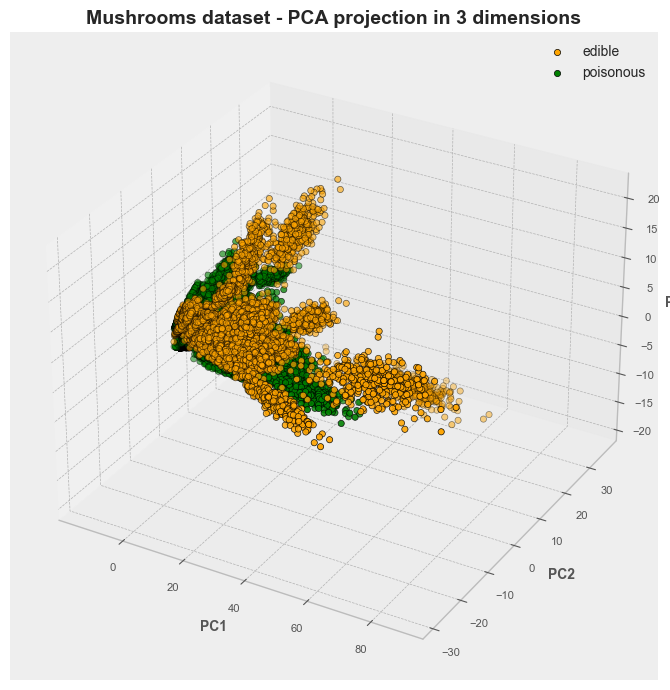

In [165]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

df_copy = df.copy()
class_labels = df_copy['class']
class_labels = np.where(class_labels == 'p', 'poisonous', 'edible') 

# Principal Component Analysis (PCA) to reduce the dimensionality of the dataset, in order to represent it in a 3D plot
pca = PCA(n_components=3)

le = LabelEncoder()
df_copy['class'] = le.fit_transform(df_copy['class'])
df_copy = pd.get_dummies(df_copy)

principal_components = pca.fit_transform(df_copy)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['class'] = class_labels

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = {'edible': 'orange', 'poisonous': 'green'}

for class_label, color in colors.items():
    df_class = df_pca[df_pca['class'] == class_label]
    ax.scatter(df_class['PC1'], df_class['PC2'], df_class['PC3'], c=colors[class_label], edgecolor='black', label=class_label)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.legend()
ax.set_title('Mushrooms dataset - PCA projection in 3 dimensions', fontsize=14, fontweight='bold')

plt.show()


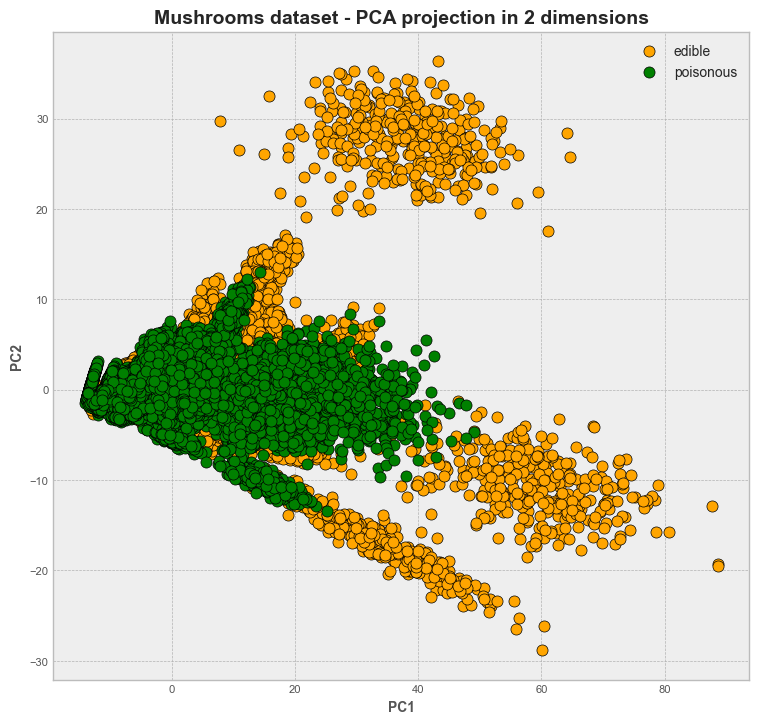

In [167]:
# Principal Component Analysis (PCA) to reduce the dimensionality of the dataset, in order to represent it in a 2D plot
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_copy)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['class'] = class_labels

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

colors = {'edible': 'orange','poisonous': 'green'}

for class_label, color in colors.items():
    df_class = df_pca[df_pca['class'] == class_label]
    ax.scatter(df_class['PC1'], df_class['PC2'], c=colors[class_label], edgecolors='black', label=class_label)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
ax.set_title('Mushrooms dataset - PCA projection in 2 dimensions', fontsize=14, fontweight='bold')
plt.show()

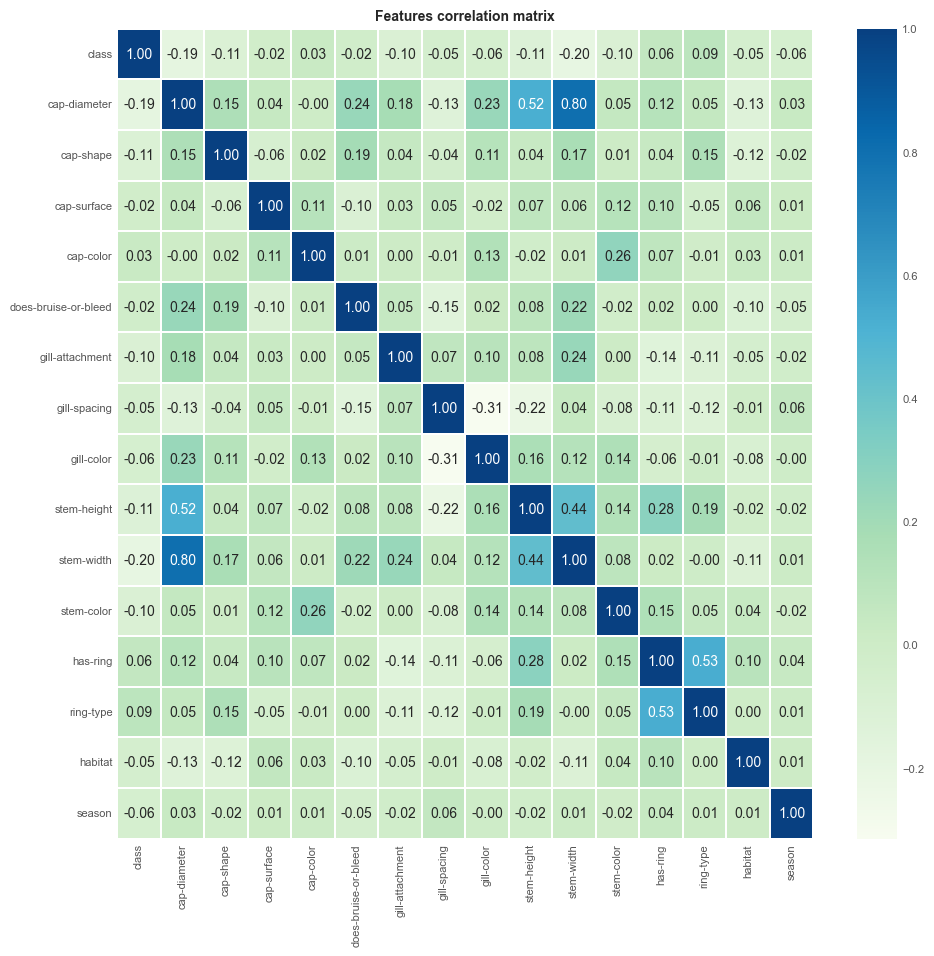

In [145]:
encoded_data = df.copy()
le = LabelEncoder()
encoded_data['class'] = le.fit_transform(df['class'])

for col in encoded_data.columns:
    encoded_data[col] = le.fit_transform(encoded_data[col])

dfDummies = pd.get_dummies(encoded_data)
plt.figure(figsize=(10,10))
sns.heatmap(dfDummies.corr(), linewidths=.1, cmap="GnBu", annot=True, fmt=".2f")
plt.title('Features correlation matrix', fontweight="bold")
plt.yticks(rotation=0)
plt.show()

In [146]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# assign to variables
data = df.copy()
X = data.drop(columns=['class'])
y = data['class']
# encoding: Label encoding for binary class, one-hot encoding for the nominal variables
# 1 for 'poisonous', 0 for 'edible'
y = np.where(y == 'p', 'poisonous', 'edible')
X = pd.get_dummies(X)
log_reg = sklearn.linear_model.LogisticRegression(max_iter=10000)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
gnb = sklearn.naive_bayes.GaussianNB()
rf = RandomForestClassifier()
models = [
    ('Logistic Regression', log_reg),
    ('Linear Discriminant Analysis', lda),
    ('Gaussian Naive Bayes', gnb),
    ('Random Forest', rf)
    ]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=100)

In [147]:
for name, model in models:
    model.fit(X_train, y_train)

In [172]:
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np
for name, model in models:
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    cval = cross_val_score(model, X, y, cv=10)
    print(cval)
    '''print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print("\n\n")'''

Model: Logistic Regression
[0.76862617 0.77746848 0.76043884 0.76535124 0.77746848 0.7810709
 0.77386606 0.77288358 0.7789422  0.76809695]
Model: Linear Discriminant Analysis
[0.76895366 0.77255608 0.76158507 0.76829867 0.77468479 0.77828721
 0.77468479 0.77484853 0.77910594 0.77038978]
Model: Gaussian Naive Bayes
[0.71393483 0.71720976 0.70656624 0.71147863 0.71377108 0.72032094
 0.72294089 0.71327984 0.71851973 0.71405175]
Model: Random Forest
[1.         1.         0.99983625 1.         0.99983625 0.99983625
 1.         0.99983625 1.         1.        ]


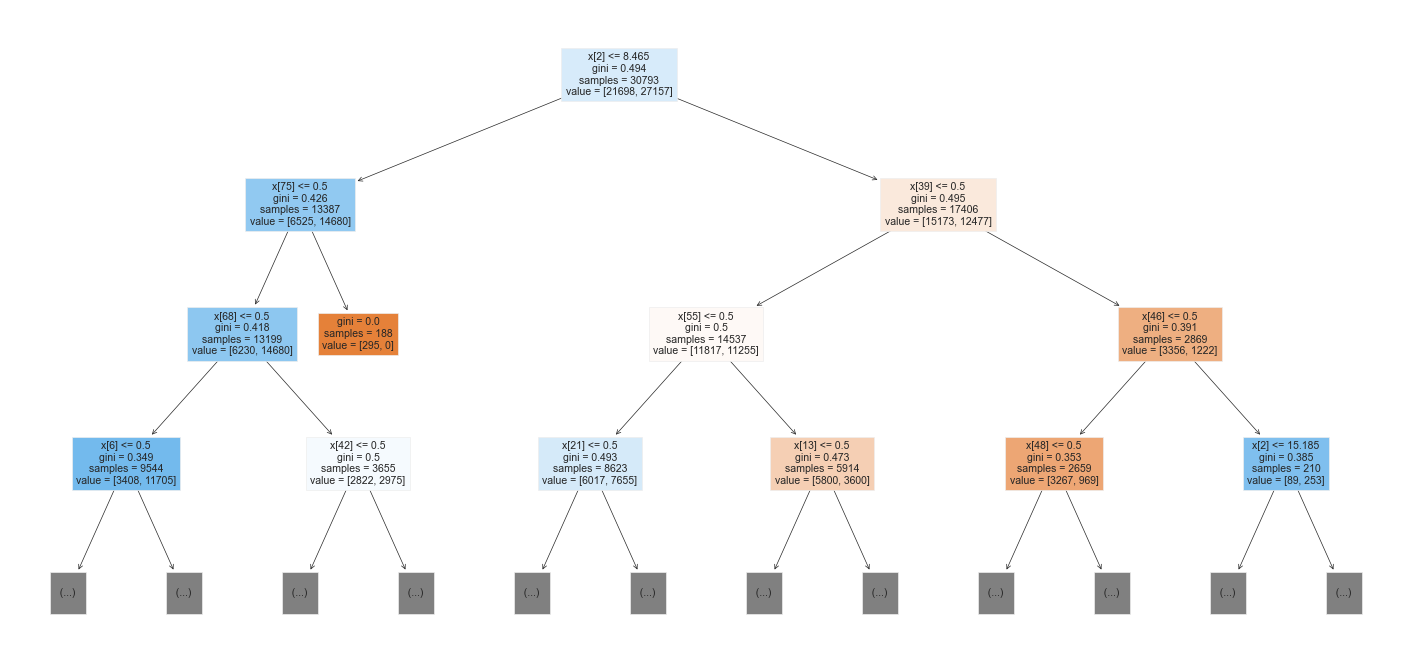

In [61]:
j = len(rf.estimators_) // 2
tree = rf.estimators_[j]

sklearn.tree.plot_tree(tree, max_depth=3, filled=True)
plt.show()

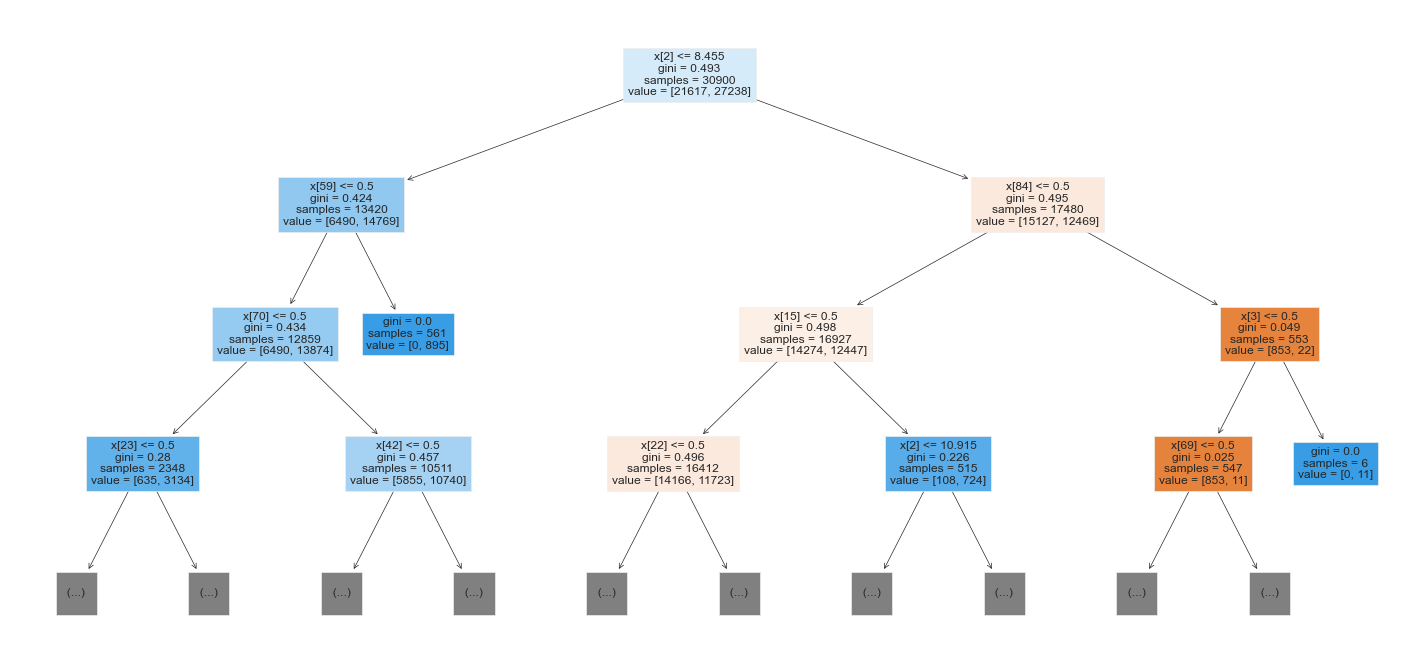

In [62]:
j = 1
tree = rf.estimators_[j]

sklearn.tree.plot_tree(tree, max_depth=3, filled=True)
plt.show()

In [63]:
param_dist = {'n_estimators': randint(1, 100),
              'max_depth': randint(1,50)}

# Create a random forest classifier
rf_constrained = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_constrained, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 48, 'n_estimators': 46}


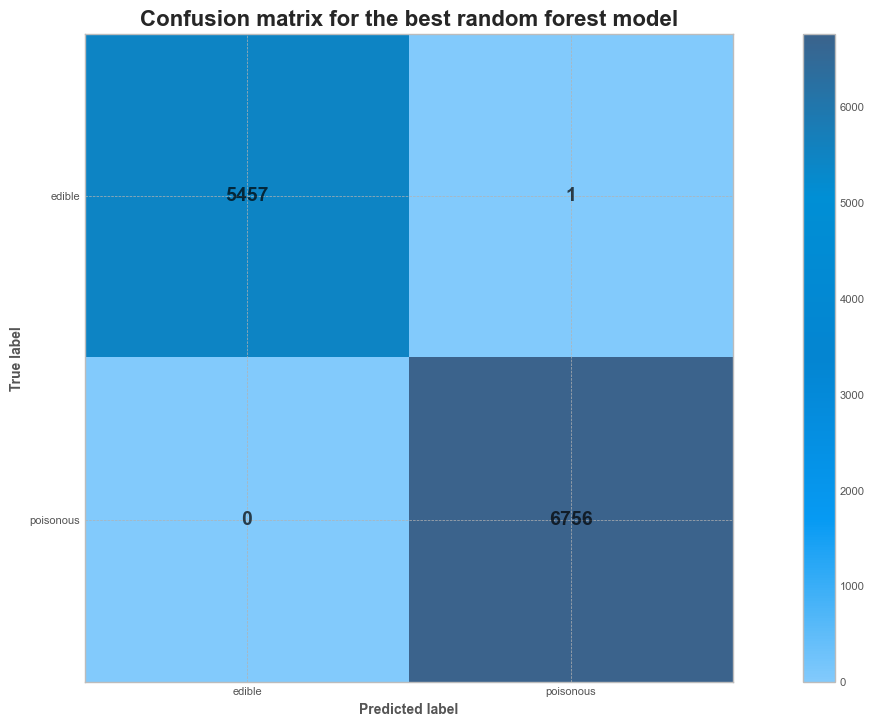

In [161]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=['edible','poisonous'])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['edible', 'poisonous']).plot(cmap=cmap, text_kw={'size':14,'fontweight':'bold', 'color':'black', 'alpha':.7})
plt.title('Confusion matrix for the best random forest model', fontsize=16, fontweight='bold')
plt.show()

In [138]:
accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)

Accuracy: 1.0


# TODO list

* Introduce k-fold cross validation and see how performances vary changing the number of folds;
* Play with RF hyperparameters, introducing constraints and see if the classificator is still good
* Let's try to introduce a threshold to give FN (classified as edible, but poisonous) a larger weight
* Comment correlation matrix in order to justify unnecessity of feature selection
* Try to change the ratio of the train/test splitting of the dataset
* Make ROC graphs of the classifiers and choose a pool of metrics to evaluate them

* _A LITTLE MORE TOUGH_: try to apply some dimensionality reduction technique

## Different class weight
Try to make False Negatives (FN) cost more than False (FP). It is a logical approach, since predicting that a poisonous mushroom is edible is way heavier than predicting that an edible mushroom is poisonous.

In [156]:
# False negatives have a cost that is 10 times higher than false positives
model = sklearn.linear_model.LogisticRegression(class_weight={'edible': 1, 'poisonous': 10}, max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      edible       0.98      0.21      0.35      5458
   poisonous       0.61      1.00      0.76      6756

    accuracy                           0.65     12214
   macro avg       0.80      0.60      0.55     12214
weighted avg       0.78      0.65      0.57     12214



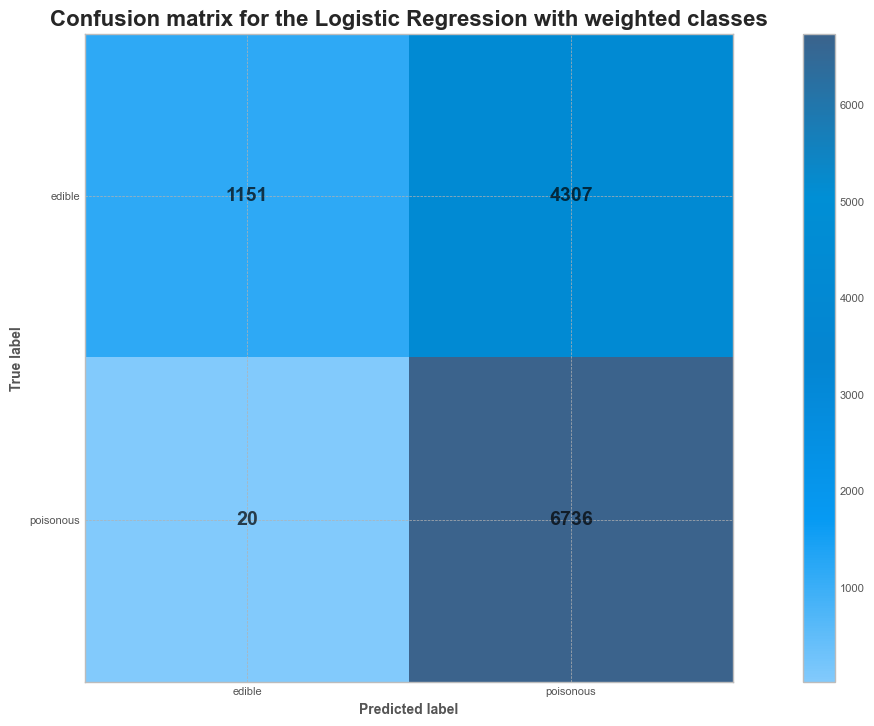

In [160]:
cm = confusion_matrix(y_test, y_pred,labels=['edible','poisonous'])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['edible', 'poisonous']).plot(cmap=cmap, text_kw={'size':14,'fontweight':'bold', 'color':'black', 'alpha':.7})
plt.title('Confusion matrix for the Logistic Regression with weighted classes', fontsize=16, fontweight='bold')
plt.xticks_labels = ['edible', 'poisonous']
plt.show()

In [198]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import auc, roc_curve

def plot_ROC(model, X, y, n_folds=5):
    #skf = StratifiedKFold(n_splits=n_folds, shuffle=False)
    skf = KFold(n_splits=n_folds, shuffle=False)
    tprs = []
    aucs = []

    mean_fpr = np.linspace(0, 1, 100)
    i = 1
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = sklearn.linear_model.LogisticRegression(max_iter=10000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1], pos_label='poisonous')
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i = i+1

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', color='b', alpha=1, lw=2)
    #plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='red', alpha=.7)

    #plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for Logistic Regression', fontweight='bold')
    plt.legend(loc='lower right')

    plt.show()

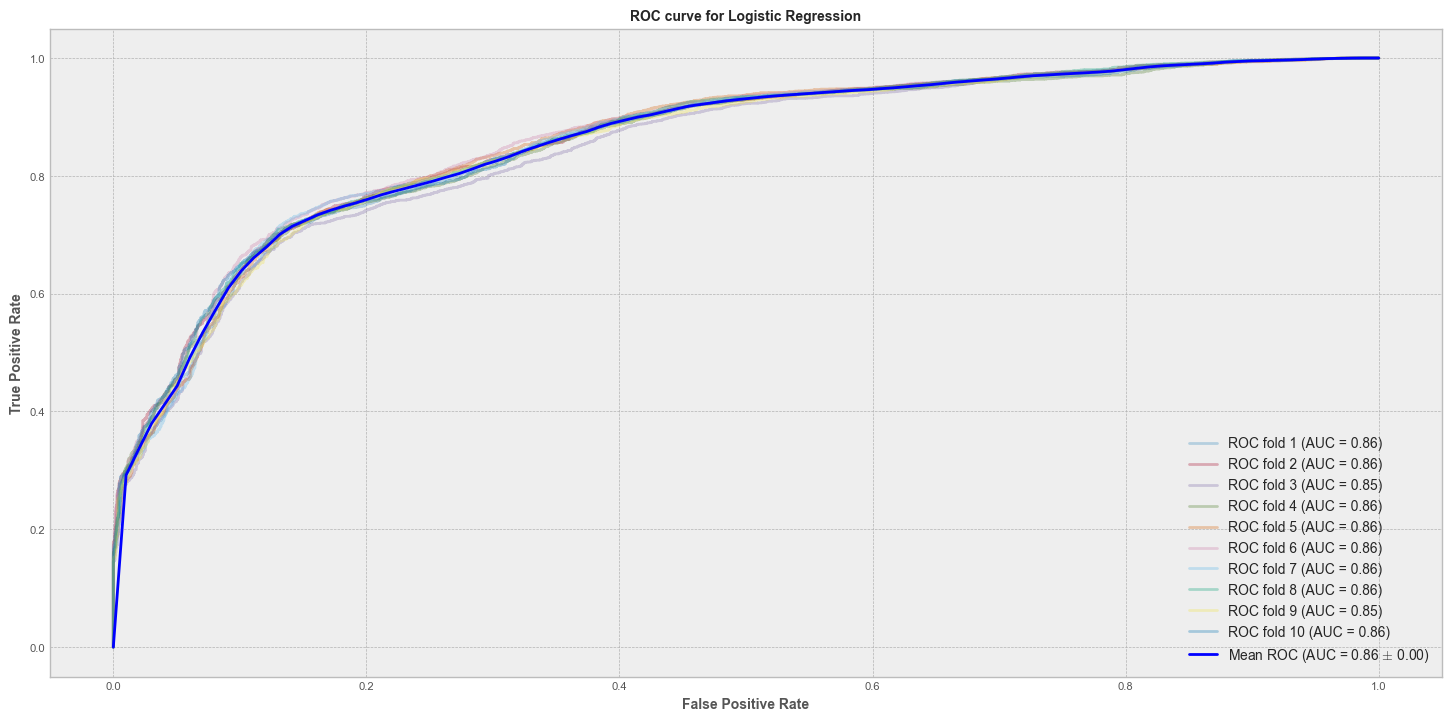

In [199]:
num_fold = 10
plot_ROC(model, X, y, num_fold)